In [1]:
from functools import partial
import logging
import os
import sys
import jax
import haiku as hk
import numpy as np
import dask
import xarray as xr
import matplotlib.pyplot as plt

from config import StackedCP0Emulator, StackedCP0Tester

from graphcast import rollout

from graphufs.training import construct_wrapped_graphcast
from graphufs.batchloader import BatchLoader
from graphufs.datasets import Dataset
from graphufs.inference import swap_batch_time_dims, store_container

/home/nagarwal/work/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")
/home/nagarwal/work/graph-ufs/graphufs/mpi.py:13: UserWarning: graphufs.mpi: Unable to import mpi4py or mpi4jax, cannot use this module
  warnings.warn(f"graphufs.mpi: Unable to import mpi4py or mpi4jax, cannot use this module")


In [16]:
def predict(
    emulator,
    dataset,
    idx=0,
    ckpt_id=49,
) -> xr.Dataset:

    params, state = emulator.load_checkpoint(id=ckpt_id)

    @hk.transform_with_state
    def run_forward(inputs, targets_template, forcings):
        predictor = construct_wrapped_graphcast(emulator)
        return predictor(inputs, targets_template=targets_template, forcings=forcings)

    def with_params(fn):
        return partial(fn, params=params, state=state)

    def drop_state(fn):
        return lambda **kw: fn(**kw)[0]

    gc = drop_state(with_params(jax.jit(run_forward.apply)))

    inputs, targets, forcings = dataset.get_xarrays(idx)
    inputs.load()
    targets.load()
    forcings.load()

    # retrieve and drop t0
    inittimes = inputs.datetime.isel(time=-2).values
    inputs = inputs.drop_vars("datetime")
    targets = targets.drop_vars("datetime")
    forcings = forcings.drop_vars("datetime")

    predictions = rollout.chunked_prediction(
        gc,
        rng=jax.random.PRNGKey(0),
        inputs=inputs,
        targets_template=np.nan * targets,
        forcings=forcings,
    )

    # Add t0 as new variable, and swap out for logical sample/batch index
    predictions = swap_batch_time_dims(predictions, inittimes)
    targets = swap_batch_time_dims(targets, inittimes)

    return predictions, targets

In [17]:
stcp0 = StackedCP0Tester()

/home/nagarwal/work/graph-ufs/graphufs/fvcoupledemulator.py:26: UserWarning: Could not import flox, install with 'conda install -c conda-forge flox' for faster volume averaging (i.e. groupby operations)
  warnings.warn("Could not import flox, install with 'conda install -c conda-forge flox' for faster volume averaging (i.e. groupby operations)")


In [18]:
vds = Dataset(stcp0, mode="validation")

In [19]:
predictions = {}
targets = {}
predictions, targets = predict(emulator=stcp0, dataset=vds)

/home/nagarwal/work/graph-ufs/graphcast/graphcast/rollout.py:127: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_target_steps = targets_template.dims["time"]
/home/nagarwal/work/graph-ufs/graphcast/graphcast/autoregressive.py:200: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  scan_length = targets_template.dims['time']
/home/nagarwal/work/graph-ufs/graphcast/graphcast/autoregressive.py:115: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension

In [20]:
predictions

<xarray.Dataset> Size: 224MB
Dimensions:    (lead_time: 40, time: 1, lat: 192, lon: 384, z_l: 4, level: 3)
Coordinates:
  * level      (level) float64 24B 497.6 698.3 899.4
  * lon        (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * lat        (lat) float64 2kB 89.82 88.89 87.95 ... -87.25 -88.18 -89.12
  * z_l        (z_l) float64 32B 25.27 120.4 238.1 384.6
  * lead_time  (lead_time) timedelta64[ns] 320B 0 days 06:00:00 ... 10 days 0...
  * time       (time) datetime64[ns] 8B 1996-01-01
Data variables:
    SSH        (lead_time, time, lat, lon) float32 12MB -0.6599 ... -0.278
    icec       (lead_time, time, lat, lon) float32 12MB 1.002 1.002 ... -0.1481
    pressfc    (lead_time, time, lat, lon) float32 12MB 1.012e+05 ... 7.058e+04
    so         (lead_time, time, z_l, lat, lon) float32 47MB 32.6 ... 0.005599
    soilm      (lead_time, time, lat, lon) float32 12MB -0.1803 ... 1.995e+03
    spfh       (lead_time, time, level, lat, lon) float32 35MB -9.806 ... -8.035
    spfh2m     (lead_time, time, lat, lon) float32 12MB -8.597 -8.597 ... -7.56
    temp       (lead_time, time, z_l, lat, lon) float32 47MB -1.75 ... -0.3142
    tmp        (lead_time, time, level, lat, lon) float32 35MB 225.6 ... 246.9

## Surface Pressure

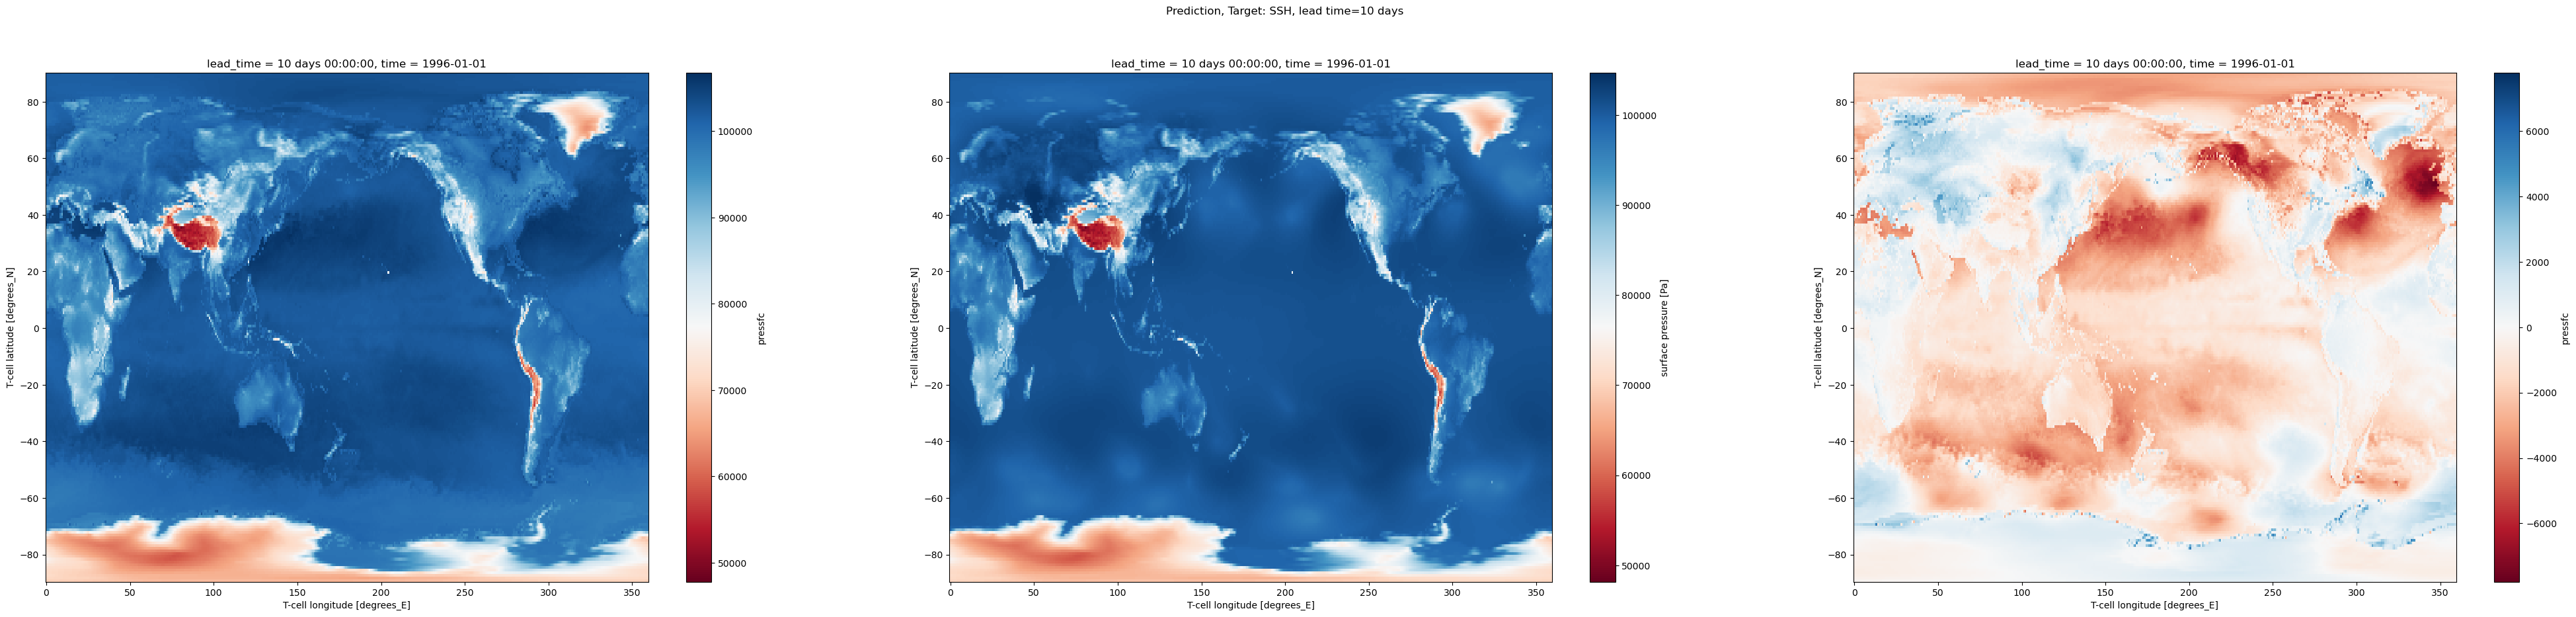

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(50,10))
predictions.pressfc.isel(time=0, lead_time=-1).plot(ax=ax[0], cmap="RdBu")
targets.pressfc.isel(time=0, lead_time=-1).plot(ax=ax[1], cmap="RdBu")
diff = targets.pressfc.isel(time=0, lead_time=-1) - predictions.pressfc.isel(time=0, lead_time=-1)
diff.plot(ax=ax[2], cmap='RdBu')
lead_time_days = predictions.lead_time[-1].values.astype('timedelta64[D]')
plt.suptitle(f'Prediction, Target: SSH, lead time={lead_time_days}')

plt.show()

## SSH

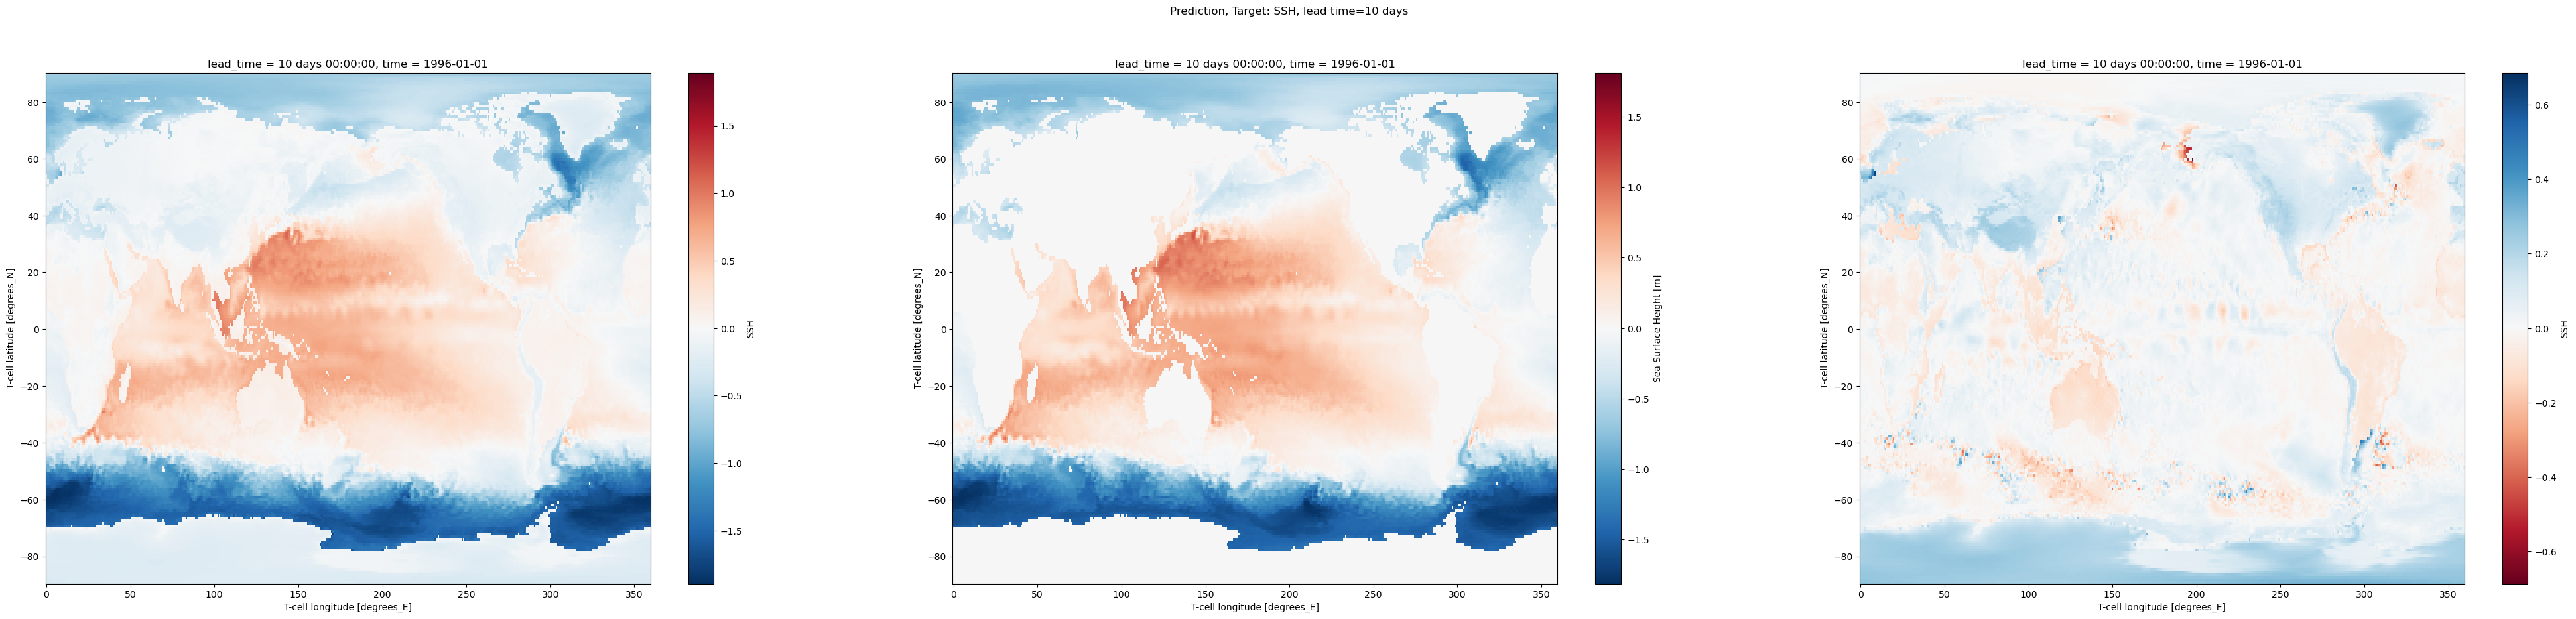

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(50,10))
predictions.SSH.isel(time=0, lead_time=-1).plot(ax=ax[0])
targets.SSH.isel(time=0, lead_time=-1).plot(ax=ax[1])
diff = targets.SSH.isel(time=0, lead_time=-1) - predictions.SSH.isel(time=0, lead_time=-1)
diff.plot(ax=ax[2], cmap='RdBu')
lead_time_days = predictions.lead_time[-1].values.astype('timedelta64[D]')
plt.suptitle(f'Prediction, Target: SSH, lead time={lead_time_days}')
plt.show()

## Sea Ice

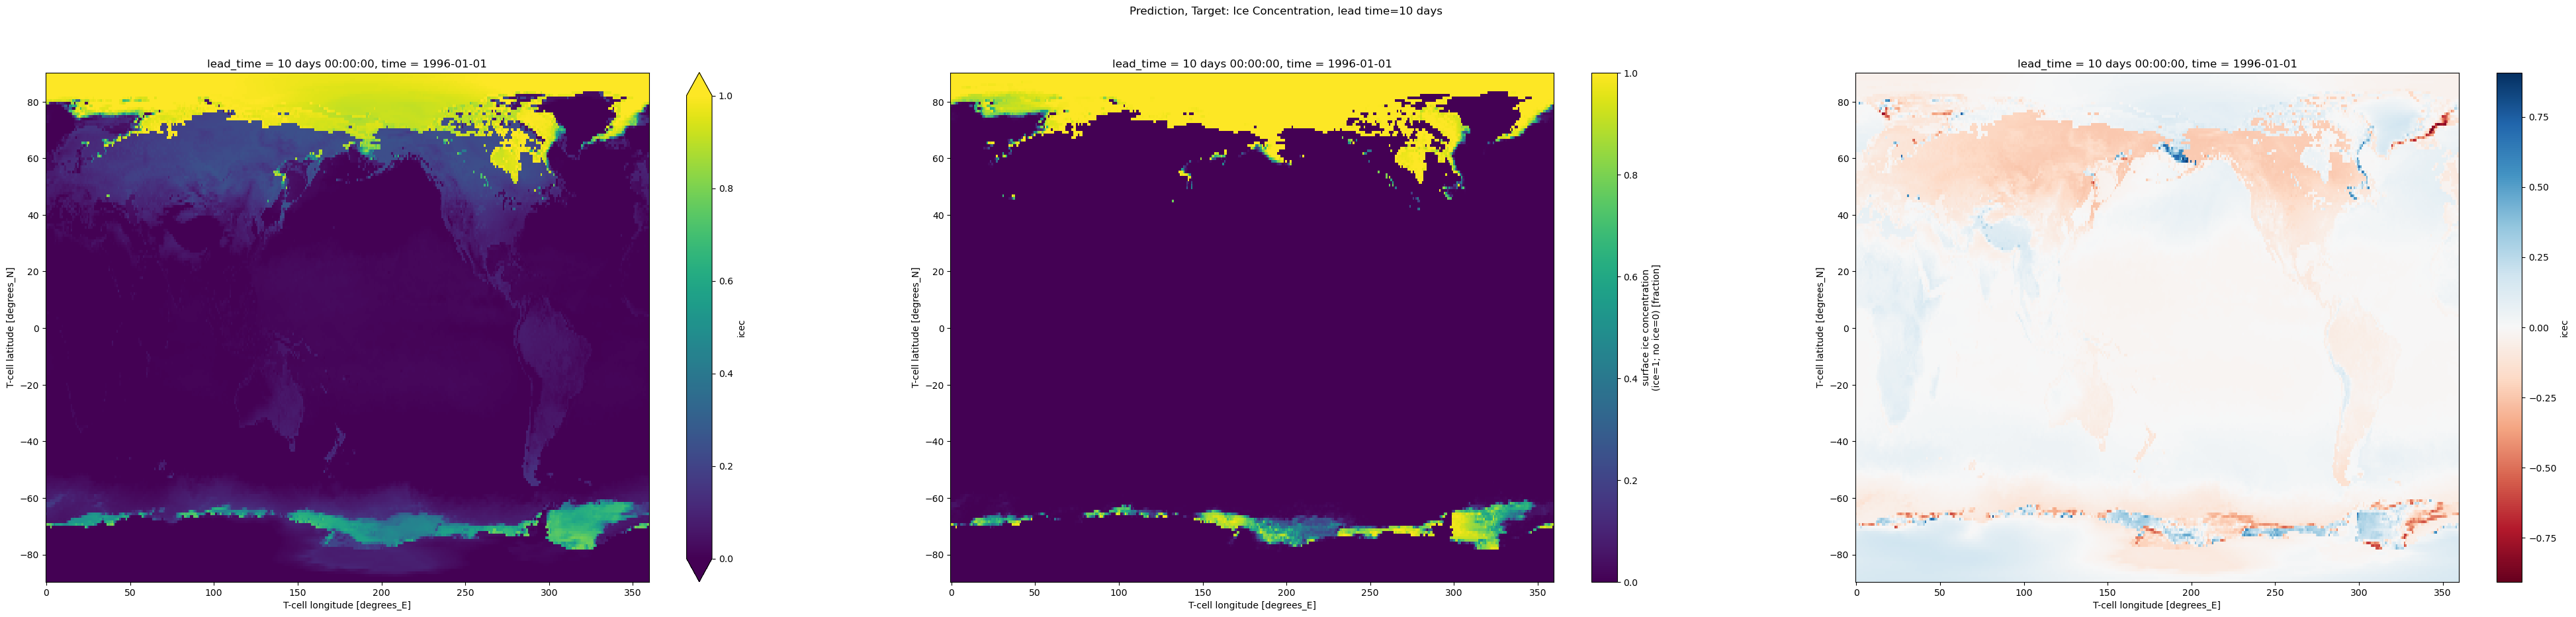

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(50,10))
predictions.icec.isel(time=0, lead_time=-1).plot(ax=ax[0], vmin=0, vmax=1, cmap="viridis")
targets.icec.isel(time=0, lead_time=-1).plot(ax=ax[1])
diff = targets.icec.isel(time=0, lead_time=-1) - predictions.icec.isel(time=0, lead_time=-1)
diff.plot(ax=ax[2], cmap='RdBu')
lead_time_days = predictions.lead_time[-1].values.astype('timedelta64[D]')
plt.suptitle(f'Prediction, Target: Ice Concentration, lead time={lead_time_days}')
plt.show()

## Soil Moisture

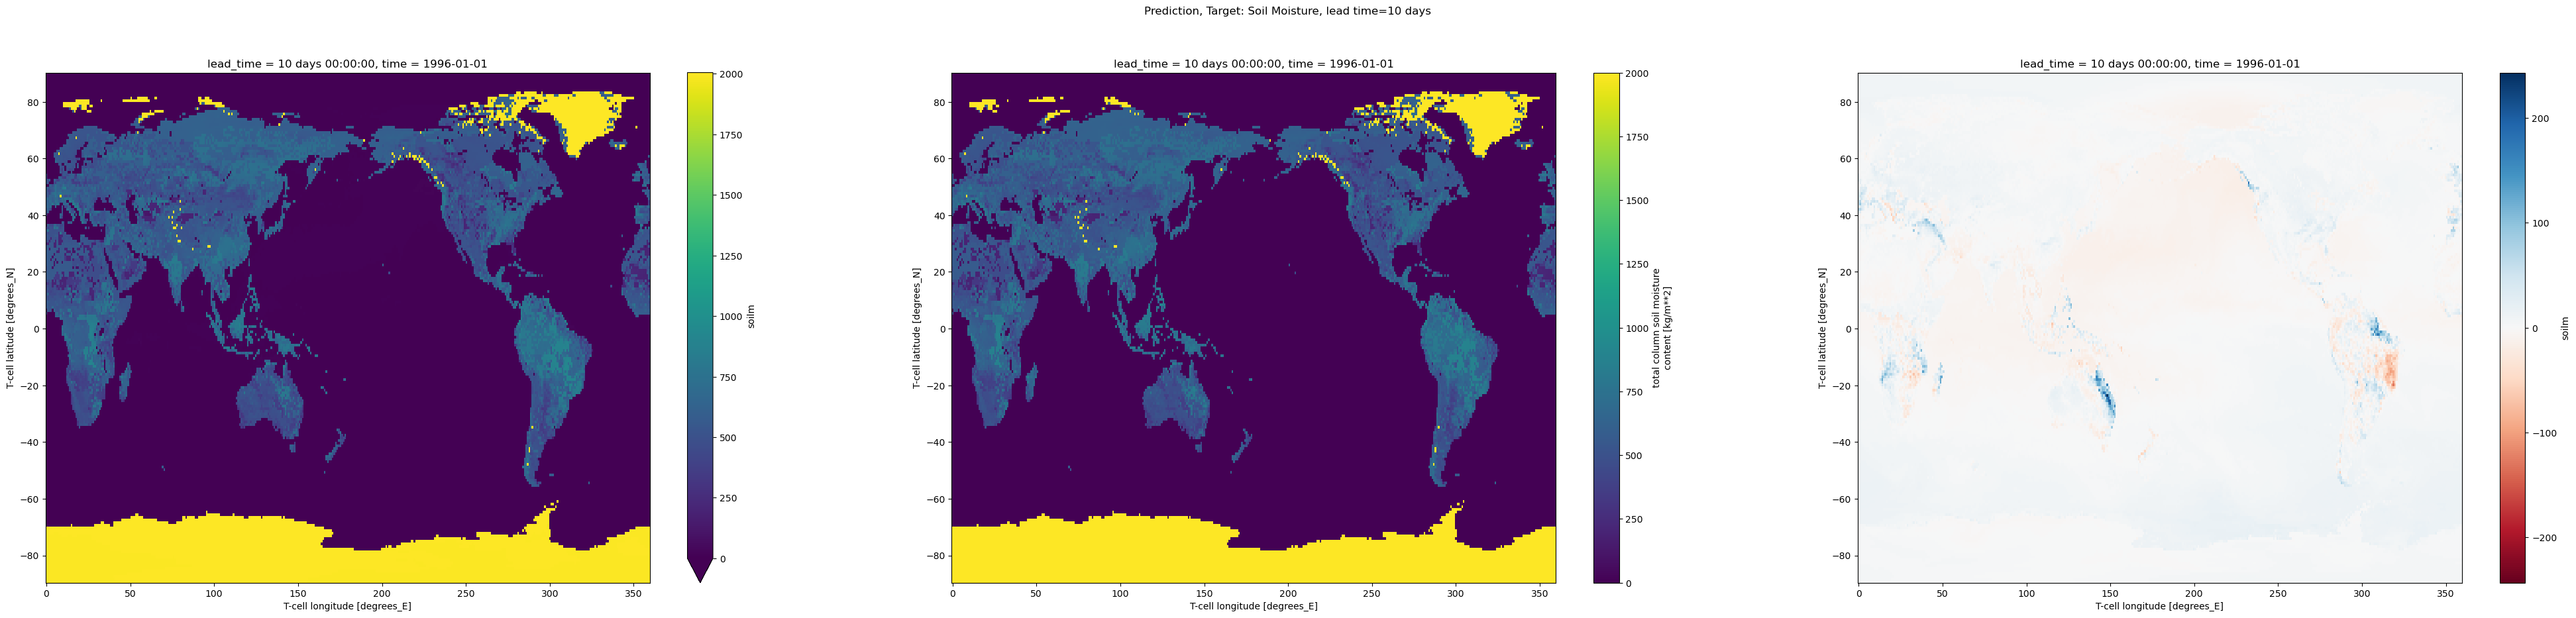

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(50,10))
predictions.soilm.isel(time=0, lead_time=-1).plot(ax=ax[0], cmap="viridis", vmin=0)
targets.soilm.isel(time=0, lead_time=-1).plot(ax=ax[1], cmap="viridis")
diff = targets.soilm.isel(time=0, lead_time=-1) - predictions.soilm.isel(time=0, lead_time=-1)
diff.plot(ax=ax[2], cmap='RdBu')
lead_time_days = predictions.lead_time[-1].values.astype('timedelta64[D]')
plt.suptitle(f'Prediction, Target: Soil Moisture, lead time={lead_time_days}')
plt.show()

## 3D ocean

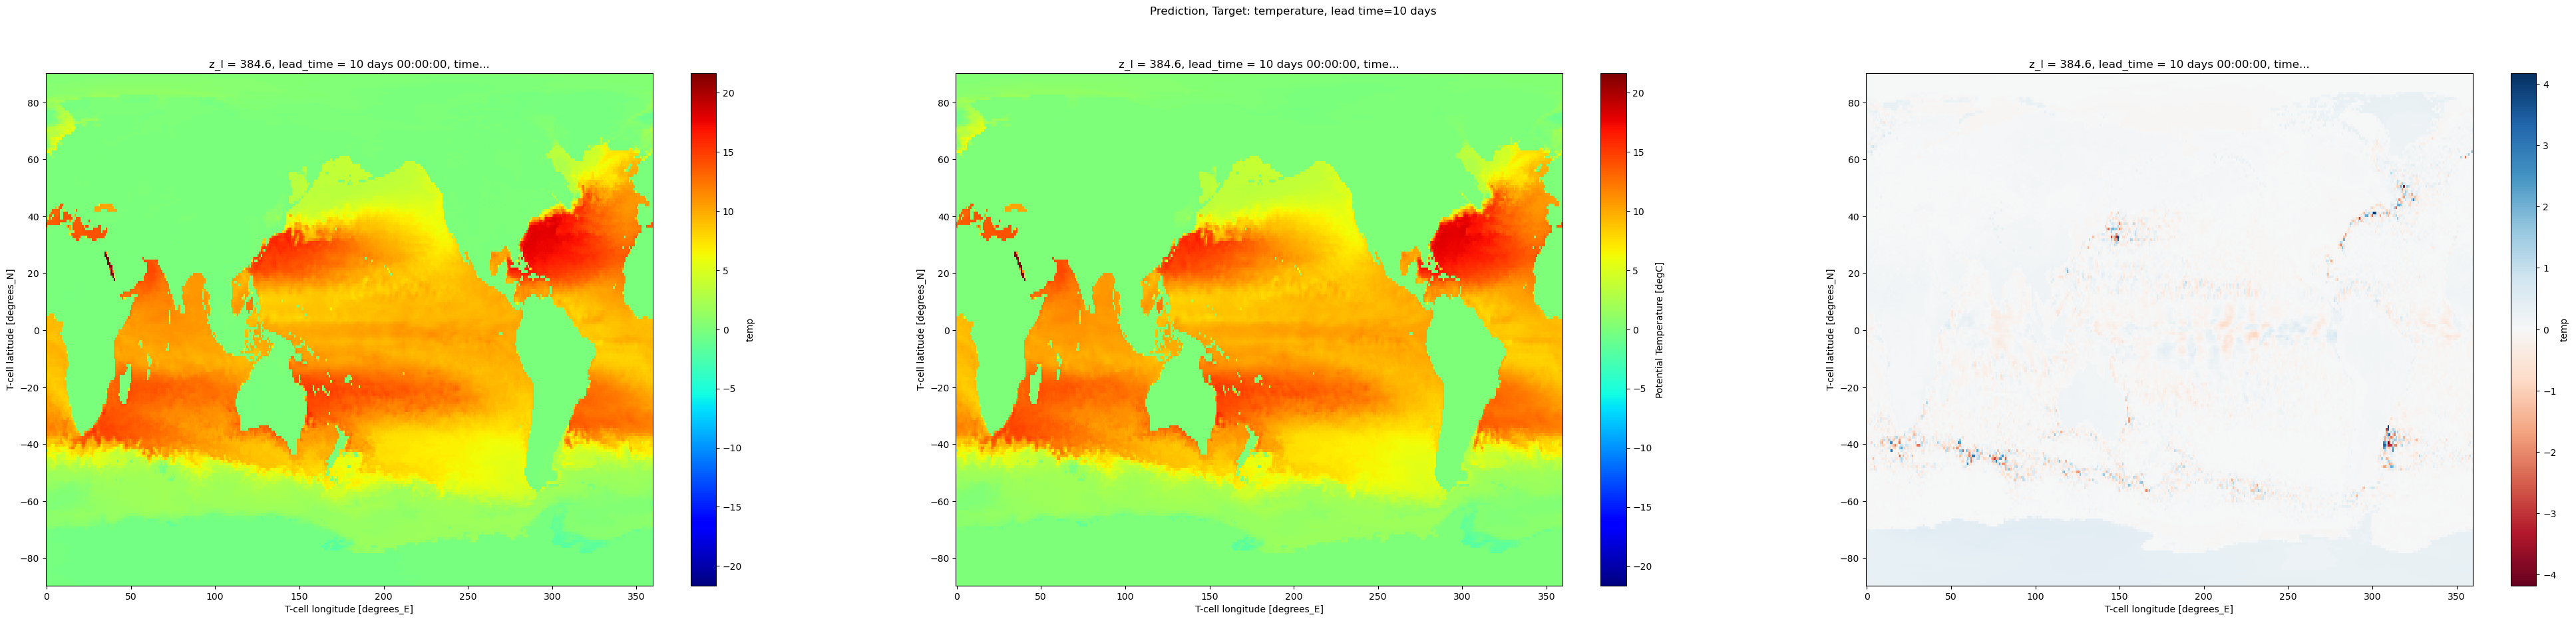

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(50,10))
predictions.temp.isel(time=0, lead_time=-1, z_l=-1).plot(ax=ax[0], cmap="jet")
targets.temp.isel(time=0, lead_time=-1, z_l=-1).plot(ax=ax[1], cmap="jet")
diff = targets.temp.isel(time=0, lead_time=-1, z_l=-1) - predictions.temp.isel(time=0, lead_time=-1, z_l=-1)
diff.plot(ax=ax[2], cmap='RdBu')
lead_time_days = predictions.lead_time[-1].values.astype('timedelta64[D]')
plt.suptitle(f'Prediction, Target: temperature, lead time={lead_time_days}')
plt.show()

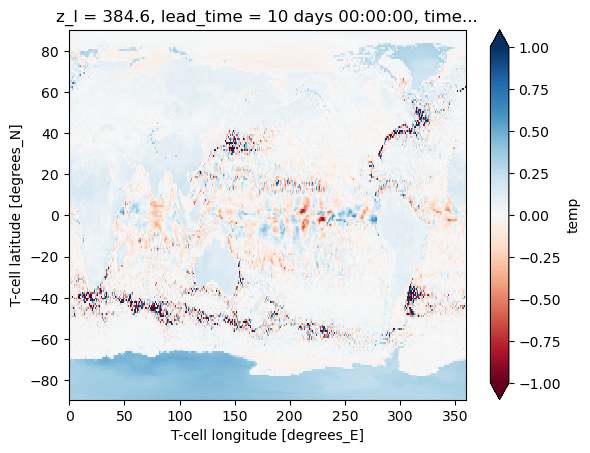

In [26]:
diff.plot(cmap='RdBu', vmin=-1, vmax=1)
plt.show()

In [31]:
print(predictions.lat[50].values)
print(predictions.lon[220].values)

42.979819538909815
206.25


In [35]:
predictions.soilm.isel(lat=50, lon=220, lead_time=-1).values

array([5.740899], dtype=float32)

In [34]:
targets.SSH.isel(lat=50, lon=220, lead_time=-1).values

array([0.08719323], dtype=float32)